# Introduction to processing seismic data

In this first notebook we will cover some basics of getting, reading, writing and processing passive seismic data.  One of the main goals of this notebook is to get you familiar with using [ObsPy](https://docs.obspy.org/), which is a Python package for Observational Seismology (and it is very helpful!).

This notebook covers the following main topics:
1. Seismic data conventions;
2. Downloading data from data-centres;
3. Plotting waveforms;
4. Reading local data;
5. Basic processing (the theory will be covered in another notebook).

In [1]:
%matplotlib widget

---
## Seismic data conventions

Before we get into looking at seismic data we should know a little about how seismic data are stored and the naming conventions. We are just going to cover passive seismic data - active source data is a whole other kettle-of-fush.

Passive seismic data are usually stored in either continuous or triggered files, where continuous files are in some standard data structure (consider the [GeoNet S3 archive](https://github.com/GeoNet/data-tutorials/tree/main/AWS_Open_Data#digital-waveform-data) on AWS) and don't have gaps (unless there is data missing). Triggered data, on the other hand, is stored in short chunks of data for particular events of interest (again GeoNet has examples of those in their [strong motion records](https://data.geonet.org.nz/seismic-products/strong-motion/volume-products/)). In either case, data are *usually* stored in a specific and standardised data format, the most common of these is [miniseed](https://ds.iris.edu/ds/nodes/dmc/data/formats/miniseed/). Useful data formats will contain not only the amplitude information recorded, but also some metadata about the station and channel that recorded it, the sampling rate of the data, and a few other useful things. Different formats store different metadata. [SAC](https://ds.iris.edu/files/sac-manual/manual/file_format.html) can store quite a lot of header information, but as you will have seen from ESCI451, in modern workflows we generally try to keep analytical results seperate from our raw data, so a lot of the extra metadata that can be stored in SAC *should* be stored in speerate files.

You don't need to understand data formats much, in part because [obspy](https://docs.obspy.org/packages/obspy.core.html#example) make reading standard data formats really simple as yoiu will see later in this notebook. You don't usually need to even know the data format: obspy will work it out for you (yay! The obspy developers are awesome).

What you do need to know, is how seismic data are named.

### SEED convention
Passive seismic data are named according to the [SEED naming convention](https://ds.iris.edu/ds/nodes/dmc/data/formats/seed-channel-naming/). This results in *seed ids* that are of the form `network.station.location.channel` where:
- `network` is a two letter identifier of the network that the station is in (GeoNet's network code is NZ).
- `station` is an identifier of five or fewer letters that name the station (note that this needs to be unique within the network)
- `location` is a two character (typically numbers) identifier to specify the location of the sensor. The code doesn't relate to any physical quantity, but just identifies a single sensor location at a given station. For example stations in the NZ national network have a broadband sensor (usually with a location code 10, unless the sensor has moved) and a strong-motion sensor (usually with a location code 20, unless the sensor has moved). An example of this is station [PYZ](https://www.geonet.org.nz/data/network/sensor/PYZ). This is to signfify the difference between a site and the actual sensor location.
- `channel` is a three character identifier that specifies the frequency band of the channel, the type of instrument, and the orientation respectively. See the [SEED naming convention](https://ds.iris.edu/ds/nodes/dmc/data/formats/seed-channel-naming/) for more details.

Using this you can work out useful things like whether you are looking at a vertical or horizontal channel, what frequencies you might expect to see, and the rough gain of the system. Quantification of these details are provided in *instrument response* files and we will look at those in a few notebooks time.

---
## Accessing FDSN data

[FDSN](https://www.fdsn.org/) stands for Federation of Digital Seismograph Networks, and is an organisation that aims to achieve good geographic seismographic coverage of the globe. Along the way to this goal the FDSN developed several standards which help to archive and distribute seismic data. It is fun to think that seismology was one of the worlds earliest truely international scientific endeavours: to be able to locate teleseismic earthquakes data from around the world is needed, so from very early on in seismology data were shared between institutions.

For our purposes, the FDSN provides a really useful standard for data access through the [FDSN web services](https://www.fdsn.org/webservices/) specifications. You don't need to know the intricacies of this, but feel free to read up if you are interested in data sharing and access! The FDSN specification covers waveform and event data as well as station meta-data.

ObsPy implements pythonic ways of accessing FDSN-compliant web-services through their [FDSN client](https://docs.obspy.org/packages/obspy.clients.fdsn.html). One such FDSN-compliant web-service is offered by [GeoNet](https://www.geonet.org.nz/data/tools/FDSN), meaning we can look at some NZ data very easily, yay!

Lets start off by instantiating a Client that can access the GeoNet web-service.  You have to instantiate a new client for each different end-point (say you want data from GeoNet and IRIS, you will need to make two Clients).

In [2]:
from obspy.clients.fdsn import Client

client = Client("GEONET")

A list of the available clients that ObsPy knows about can be found [here](https://docs.obspy.org/packages/obspy.clients.fdsn.html#id1), and includes the raspberry shake network that we might have connected our raspberry shakes to earlier! If we didn't, then you can check out the data for the Raspberry Shake in the Geophysics Vault on the 1st floor of cotton building [here](https://dataview.raspberryshake.org/#/AM/RAC6D/00/EHZ?streaming=on).

We can get three types of data from FDSN-compliant web-services (although not all offer all three - RASPISHAKE only provides waveform data for example):
1. Station meta-data

In [3]:
import warnings  # GeoNet doesn't fully specify the stationXML version and ObsPy complains, we can ignore that

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    inventory = client.get_stations(
        network="NZ", station="FOZ", location="10", channel="HHZ")
# This inventory contains a single network, we can run print(inventory) to see this, or we can look at that network
print(inventory.networks[0])

Network NZ (New Zealand National Seismograph Network)
	Station Count: 1/2134 (Selected/Total)
	1884-02-01T00:00:00.000000Z - --
	Access: open
	Contains:
		Stations (1):
			NZ.FOZ (Fox Glacier)
		Channels (0):



2. Event information

In [4]:
catalog = client.get_events(eventid="2016p858000")
print(catalog)

1 Event(s) in Catalog:
2016-11-13T11:02:56.346094Z | -42.693, +173.022 | 7.82 Mw(mB) | manual


3. Waveform information

In [5]:
# We need to specify a start and end-time. To do that we use ObsPy's UTCDateTime object
from obspy import UTCDateTime

st = client.get_waveforms(
    network="NZ", station="FOZ", location="10", channel="HHZ",
    starttime=UTCDateTime(2016, 11, 13, 11),
    endtime=UTCDateTime(2016, 11, 13, 11, 20))
print(st)

1 Trace(s) in Stream:
NZ.FOZ.10.HHZ | 2016-11-13T10:59:59.998393Z - 2016-11-13T11:19:59.998393Z | 100.0 Hz, 120001 samples


---
### Basic plotting

Obspy has nice quick ways to plot a few things, including waveforms. The object that we got from the `client.get_waveforms` call above is a [`Stream`](https://docs.obspy.org/tutorial/code_snippets/reading_seismograms.html). Check out the linked tutorial for more information on `Stream` objects.

To get these plots to play nice in the notebooks (to have a zoomable window) we need to set up a figure first. However, outside of Jupyter you can just plot using:

```python
st.plot()
```

give it a go below:

In [6]:
# your code here:

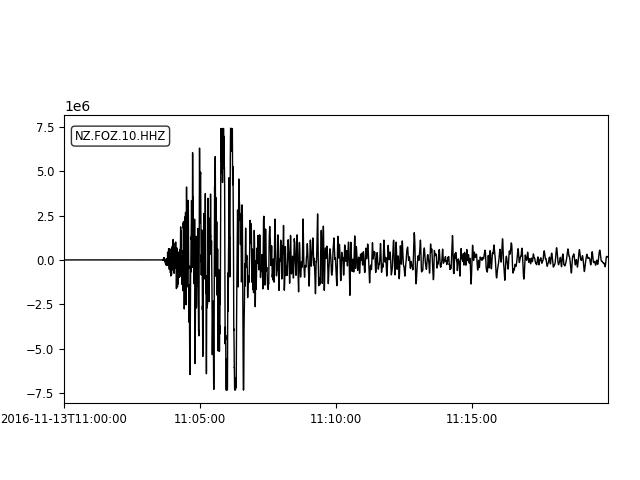

In [7]:
# To make the figure zoomable we have to pass a figure to plot:
import matplotlib.pyplot as plt

fig = plt.figure()
fig = st.plot(fig=fig, show=False)

plt.show()

**Bonus points** what earthquake is this data for, and where is the seismograph?

---
## An aside on time

Seismic data are recorded at fairly high sampling rates (often > 50 samples per second, more on the effect of sampling rates later). To be able to work with that we need a fairly high precision way of representing times. ObsPy has it's own `UTCDateTime` class that handles times to the required precision. These are used throughout ObsPy and have some handy things, most notably, adding seconds to them!

For example, to make a `UTCDateTime` object we can pass a year, month, day, hour, minute, second and nanosecond like this:

In [8]:
UTCDateTime(2017, 2, 11, 13, 12, 24, 4000)

2017-02-11T13:12:24.004000Z

Check out the [docs on UTCDateTime](https://docs.obspy.org/packages/autogen/obspy.core.utcdatetime.UTCDateTime.html) for more options.

We can then do maths with them - we can add seconds directly, for example if I wanted a time 20.5 seconds after the time above I could do:

In [9]:
UTCDateTime(2017, 2, 11, 13, 12, 24, 4000) + 20.5

2017-02-11T13:12:44.504000Z

If you need raw `datetime` objects (for example for plotting), then you can get one using the `.datetime` property of `UTCDateTime` objects, like so:

In [10]:
sometime = UTCDateTime(2017, 2, 11, 13, 12, 24, 4000)
sometime.datetime

datetime.datetime(2017, 2, 11, 13, 12, 24, 4000)

---
## Getting more data

Now we know how time works (in ObsPy at least), you should be able to get some data for yourself. Use the `client.get_waveforms` method we used before, but this time get data for:
- network: NZ
- station: JCZ
- channel: HHN
- location: 10
- starttime: 2016/11/13 00:00
and length of one day (hint, just add 86400 seconds onto the starttime).

Download and plot these data below:

In [11]:
# Your turn

### Multiple stations

We can get data for multiple stations and store it in an ObsPy `Stream`. One way to do that is to add `Stream`s together like so:

In [12]:
st = client.get_waveforms(
    network="NZ", station="FOZ", location="10", channel="HHZ",
    starttime=UTCDateTime(2016, 11, 13, 11),
    endtime=UTCDateTime(2016, 11, 13, 11, 20))
st += client.get_waveforms(
    network="NZ", station="JCZ", location="10", channel="HHZ",
    starttime=UTCDateTime(2016, 11, 13, 11),
    endtime=UTCDateTime(2016, 11, 13, 11, 20))
print(st)

2 Trace(s) in Stream:
NZ.FOZ.10.HHZ | 2016-11-13T10:59:59.998393Z - 2016-11-13T11:19:59.998393Z | 100.0 Hz, 120001 samples
NZ.JCZ.10.HHZ | 2016-11-13T10:59:59.998393Z - 2016-11-13T11:19:59.998393Z | 100.0 Hz, 120001 samples


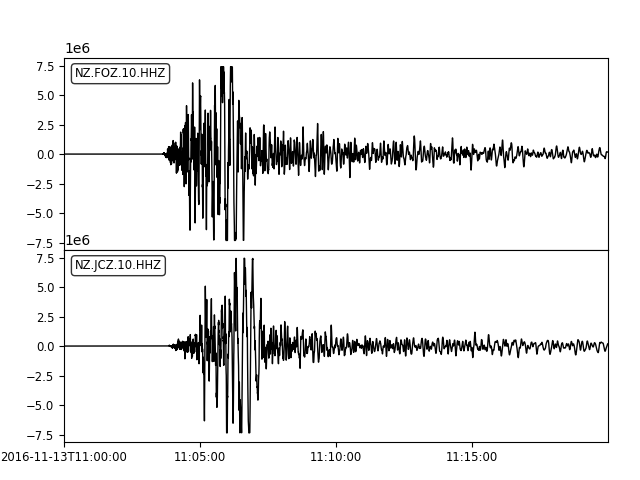

In [13]:
fig = plt.figure()
_ = st.plot(fig=fig, show=False)

plt.show()

This `Stream` has two `Trace`s in it - we can access individual `Trace`s using normal list indexing like:

In [14]:
tr = st[0]
print(tr)

NZ.FOZ.10.HHZ | 2016-11-13T10:59:59.998393Z - 2016-11-13T11:19:59.998393Z | 100.0 Hz, 120001 samples


We can also get data from multiple stations using *"wildcard"* queries, where a `*` counts for any string, and a `?` matches any letter. For example if we want all three HH channels from FOZ we can use:

In [15]:
st = client.get_waveforms(
    network="NZ", station="FOZ", location="10", channel="HH?",  # Note the ? in the channel argument
    starttime=UTCDateTime(2016, 11, 13, 11),
    endtime=UTCDateTime(2016, 11, 13, 11, 20))
print(st)

3 Trace(s) in Stream:
NZ.FOZ.10.HHE | 2016-11-13T10:59:59.998393Z - 2016-11-13T11:19:59.998393Z | 100.0 Hz, 120001 samples
NZ.FOZ.10.HHN | 2016-11-13T10:59:59.998393Z - 2016-11-13T11:19:59.998393Z | 100.0 Hz, 120001 samples
NZ.FOZ.10.HHZ | 2016-11-13T10:59:59.998393Z - 2016-11-13T11:19:59.998393Z | 100.0 Hz, 120001 samples


Okay, lets put that all together and download 10 minutes of data for all stations within 100 km of the Kaikoura epicentre (GeoNet has it at -42.69, 173.02).

To start with we can get an inventory of all the stations within 1 degree of a point using code like:

In [16]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    inv = client.get_stations(latitude=-42.69, longitude=173.02, maxradius=1, level="station")
print(inv)

Inventory created at 2023-02-15T04:59:46.000000Z
	Created by: Delta
		    
	Sending institution: GeoNet (WEL(GNS_Test))
	Contains:
		Networks (1):
			NZ
		Stations (229):
			NZ.042A (Hanmer Springs Fire Station)
			NZ.042B (Hanmer Springs Emergency Centre)
			NZ.053A (Maruia Springs Hotel)
			NZ.060A (Cheviot Post Office)
			NZ.060B (Cheviot Police Station)
			NZ.060C (Cheviot Emergency Centre)
			NZ.097A (Springs Junction Fire Station)
			NZ.103A (Springs Junction Ranger Station)
			NZ.103B (Springs Junction Ranger Station)
			NZ.256A (Maruia Springs Hotel)
			NZ.270A (Kaikoura Telephone Exchange)
			NZ.270B (Kaikoura Marine Laboratory)
			NZ.271A (Hanmer Springs Fire Station)
			NZ.273A (Christchurch Arts Centre)
			NZ.274A (Canterbury University Engineering School)
			NZ.275A (Christchurch International Airport)
			NZ.276A (Cheviot Post Office)
			NZ.501A (Christchurch Police Station A)
			NZ.501B (Christchurch Police Station B)
			NZ.501C (Christchurch Police Station C)
			NZ.501D 

That is quite a lot of stations! Lets just restrict ourselves to broadband instruments with channels `HH?`:

In [17]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    inv = client.get_stations(latitude=-42.69, longitude=173.02, maxradius=1, level="station", channel="HH?")
print(inv)

Inventory created at 2023-02-15T04:59:46.000000Z
	Created by: Delta
		    
	Sending institution: GeoNet (WEL(GNS_Test))
	Contains:
		Networks (1):
			NZ
		Stations (13):
			NZ.AC1A (Acheron #1)
			NZ.AC2A (Acheron #2)
			NZ.AC3A (Acheron #3)
			NZ.AC5A (Acheron #5)
			NZ.GR1A (Grey #1)
			NZ.GR2A (Grey #2)
			NZ.GR3A (Grey #3)
			NZ.GR5A (Grey #5)
			NZ.GVZ (Greta Valley)
			NZ.KHZ (Kahutara)
			NZ.LTZ (Lake Taylor Station)
			NZ.OXZ (Oxford)
			NZ.THZ (Top House)
		Channels (0):



It turns out this includes stations operating not within the time period we are interested in (around Kaikoura), we can specify another couple of arguments, `startbefore` and `endafter` to make sure that we only get stations that should have data when we want it.  I'm going to set a starttime and endtime variable that we can use later as well:

In [18]:
starttime = UTCDateTime(2016, 11, 13, 11)
endtime = starttime + 10 * 60

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    inv = client.get_stations(
        latitude=-42.29, longitude=173.02, maxradius=1, level="station", channel="HH?",
        startbefore=starttime, endafter=endtime)
print(inv)

Inventory created at 2023-02-15T04:59:46.000000Z
	Created by: Delta
		    
	Sending institution: GeoNet (WEL(GNS_Test))
	Contains:
		Networks (1):
			NZ
		Stations (4):
			NZ.GVZ (Greta Valley)
			NZ.KHZ (Kahutara)
			NZ.LTZ (Lake Taylor Station)
			NZ.THZ (Top House)
		Channels (0):



Okay, now we know what stations we want we can download them - we can use a loop for this!

We will start with an empty `Stream` and add to it:

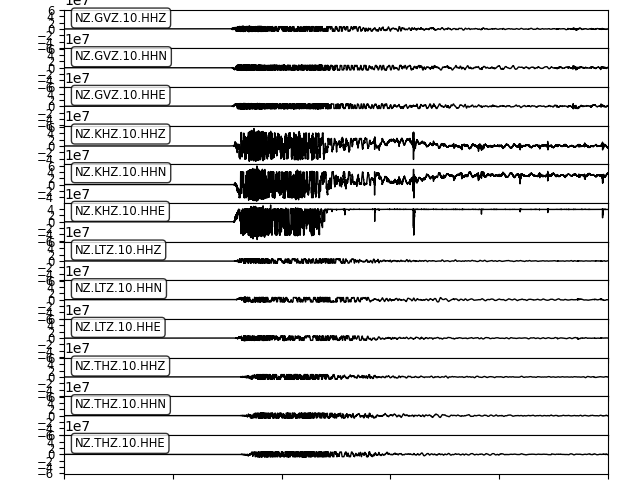

In [19]:
from obspy import Stream

st = Stream()
for network in inv:  # The first level of the inventory hierachy
    for station in network:  # The second level of the inventory hierachy
        st += client.get_waveforms(
            network=network.code, station=station.code, location="*", channel="HH?",
            starttime=starttime, endtime=endtime)
fig = plt.figure()
_ = st.plot(fig=fig, show=False)

plt.show()

Cool! Those waveforms look horrible - who knows what is going on here?


---
## Metadata

`Trace` objects contain not only the data, but also some useful metadata that explain the seismic data.  These are contained within the `trace.stats` attribute.  Lets look at one now:

In [20]:
print(st[0].stats)

               network: NZ
               station: GVZ
              location: 10
               channel: HHE
             starttime: 2016-11-13T10:59:59.998393Z
               endtime: 2016-11-13T11:09:59.998393Z
         sampling_rate: 100.0
                 delta: 0.01
                  npts: 60001
                 calib: 1.0
_fdsnws_dataselect_url: http://service.geonet.org.nz/fdsnws/dataselect/1/query
               _format: MSEED
                 mseed: AttribDict({'dataquality': 'D', 'number_of_records': 388, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 512, 'filesize': 587776})
            processing: ['ObsPy 1.4.0: trim(endtime=UTCDateTime(2016, 11, 13, 11, 9, 59, 998393)::fill_value=None::nearest_sample=True::pad=False::starttime=UTCDateTime(2016, 11, 13, 10, 59, 59, 998393))']


This tells us lots of useful information - the sampling rate, and sampling interval, the naming used for the station, the start and end time of the trace, and some information about how the data were processed and retrieved from the FDSN client.

## Getting data for an event

So we just downloaded data for one event - we could to this for any event, but the best way to do this is probably going to be using a function.

To start with, the things that we needed were the location of the event, and the time of the event.  We can get that from the `Event` downloaded from the FDSN:

In [21]:
cat = client.get_events(eventid="2016p858000")
event = cat[0]  # A catalog is just a list of events with a few handy methods on top

origin = event.preferred_origin()  # an event can contain multiple origins, but one is usually set as the best
print(origin)

Origin
	        resource_id: ResourceIdentifier(id="smi:nz.org.geonet/Origin#20161116052725.210418.52361")
	               time: UTCDateTime(2016, 11, 13, 11, 2, 56, 346094) [confidence_level=89.99999762, uncertainty=0.3114605068]
	          longitude: 173.0221405 [confidence_level=89.99999762, uncertainty=3.42338418]
	           latitude: -42.6925354 [confidence_level=89.99999762, uncertainty=2.342521173]
	              depth: 15114.45332 [confidence_level=89.99999762, uncertainty=3593.426501]
	          method_id: ResourceIdentifier(id="smi:nz.org.geonet/LOCSAT")
	     earth_model_id: ResourceIdentifier(id="smi:nz.org.geonet/iasp91")
	            quality: OriginQuality(associated_phase_count=189, used_phase_count=94, associated_station_count=186, used_station_count=93, depth_phase_count=0, standard_error=1.822964596, azimuthal_gap=54.98503113, minimum_distance=0.2205573916, maximum_distance=7.640860558, median_distance=5.064006805)
	 origin_uncertainty: OriginUncertainty(horizontal_u

You will see that there is lots of information in there, but crucially there is also `time`, `longitude` and `latitude`, that we need to specify the region and start and end time of our downloaded data.

Try making a function that takes an event-id, a `Client` and a radius and downloads the broadband stations for that event.  I have started writing some psuedo-code below for you:

In [22]:
def get_data_for_event(event_id, client, maxradius, duration):
    """
    Get data for broadband stations within maxradius of an event.
    
    Parameters
    ----------
    event_id
        event-id to get data for
    client
        FDSN client to get data from
    maxradius
        Maximum radius to get stations for in degrees
    duration
        Duration to download in seconds
        
    Returns
    -------
    stream
    """
    # Download the event of interest
    
    # Get the stations within maxradius of the event origin and operational during the time window of interest
    # inv = client.get_stations
    
    # Download the waveforms for those stations
    st = Stream()
    #for network in inv:
    #    for station in network:
    
    # Return the Stream!
    return st

Now that you have a function, use it to get the data for broadband stations within 200 km of the 2009 Dusky Sound Magnitude 7.8 earthquake, and plot the waveforms. Do you see the same clipping of high amplitudes that we saw with the Kaikoura earthquake?

You can also try getting data from the strong motion stations (that have channel codes HN?) and see if they clip or not.

In [23]:
# Your code here

## A quick look at frequency content

Obspy also has a nice way to look at the frequency content of waveforms.  We can plot a waveforms [spectrogram](https://docs.obspy.org/tutorial/code_snippets/plotting_spectrograms.html) fairly simply:

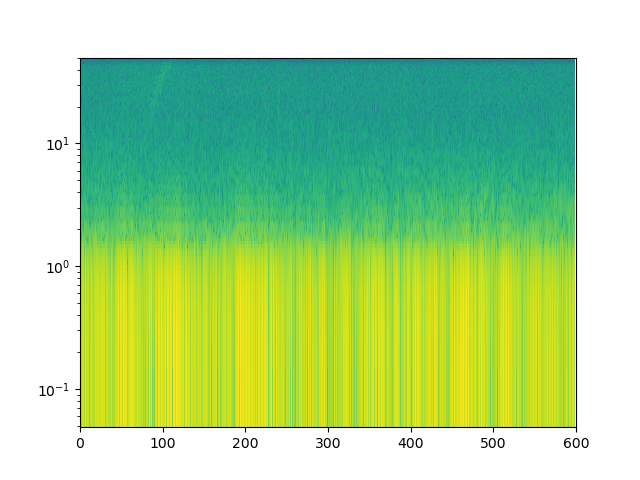

In [24]:
st = client.get_waveforms(
    network="NZ", station="FOZ", location="10", channel="HHZ",
    starttime=UTCDateTime(2014, 11, 1, 0, 0),
    endtime=UTCDateTime(2014, 11, 1, 0, 10))
fig, ax = plt.subplots()
_ = st.spectrogram(log=True, dbscale=True, axes=ax, show=False)

plt.show()

What this is showing us is the power in each frequency band (along the y-axis) for every few samples in time (along the x-axis).  We will talk more about this in the lab on Fourier Analysis. For now, you need to know that warmer colours indicate more power - this station has most of it's power below 1 Hz, which is common for a time-period dominated by seismic noise. 

Lets compare that to when there was an earthquake nearby the site:

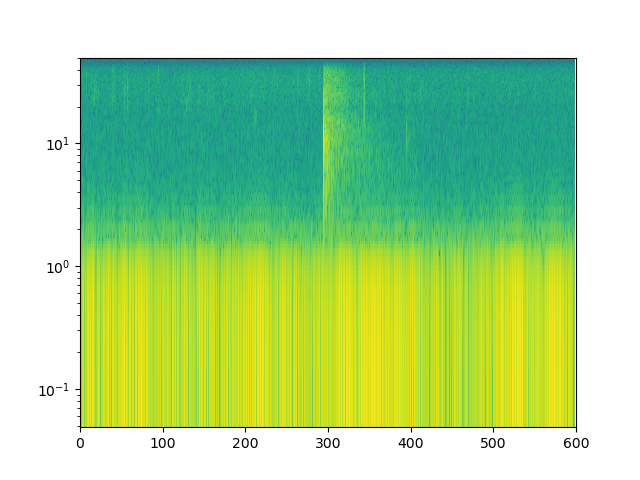

In [25]:
st = client.get_waveforms(
    network="NZ", station="FOZ", location="11", channel="HHZ",  # Location code changed for FOZ.
    starttime=UTCDateTime(2021, 2, 2, 13, 40),
    endtime=UTCDateTime(2021, 2, 2, 13, 50))
fig, ax = plt.subplots()
_ = st.spectrogram(log=True, dbscale=True, axes=ax, show=False)

plt.show()

You should just be able to make out a little bright patch around x=850 around 10 Hz - that is the earthquake! Try zooming in to get a better look at that peak.

Earthquakes generally start off emitting a broad range of frequencies, including much higher frequencies than noise.  Higher frequencies attenuate faster, so we don't usually record frequencies above 20 Hz for earthquakes recorded beyond a few km away.

Try downloading some data that you are interested in and looking at the spectrogram - volcanoes produce some interesting frequencies!

In [26]:
# Your code here

---
## Reading local data

We will mostly work with GeoNet data in this course, but you can also read local data in ObsPy.  You should have been provided with a file "COSA_kaik.ms" which contains data from SAMBA site COSA, between Fox Glacier and Franz Josef, for the day of the Kaikōura earthquake.

You can read most common seismological data formats in ObsPy just by running:
```python
from obspy import read

st = read("filename")
```
where filename is the name of the file you want to read (the full-path!). 

Try this now with the data file provided, and plot the data and the spectrogram:

In [27]:
# Read some local data!

---
## Basic processing

We will spend more time on the theory of signal processing next time, but I want to introduce two things here:
1. Filtering
2. Resampling and decimating

We saw that there was a lot of low frequency noise in our spectrograms. We can filter that out fairly easily in ObsPy with a highpass/lowcut filter. Remember that:
- "bandpass" filters retain frequencies *within* a frequency range;
- "lowpass" filters retain frequencies *below* a frequency;
- "highpass" filters retain frequencies *above* a frequency;
- "notch" filters *remove* frequencies within a range (the opposite of bandpass).

You can filter data in obspy using the `trace.filter` method - you can find more information on this [here](https://docs.obspy.org/packages/autogen/obspy.core.trace.Trace.filter.html).

Lets try that with our FOZ earthquake data, with a highpass of 2 Hz:

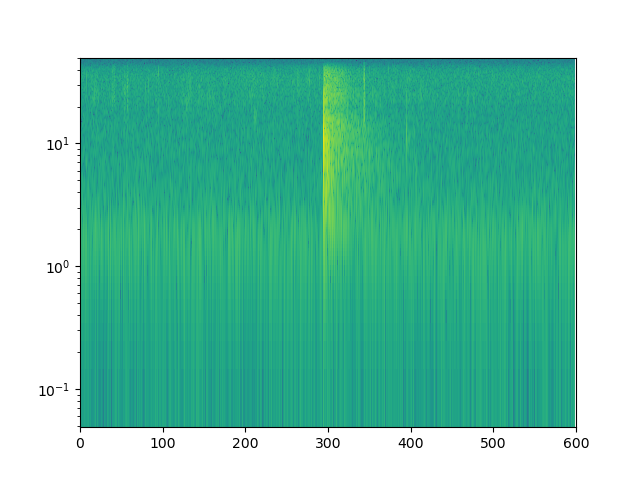

In [28]:
st = client.get_waveforms(
    network="NZ", station="FOZ", location="11", channel="HHZ",  # Location code changed for FOZ.
    starttime=UTCDateTime(2021, 2, 2, 13, 40),
    endtime=UTCDateTime(2021, 2, 2, 13, 50))

# Filter!
st.filter("highpass", freq=2.0)

fig, ax = plt.subplots()
_ = st.spectrogram(log=True, dbscale=True, axes=ax, show=False)

plt.show()

You can see that we lost the low frequency noise!

Try plotting the trace/stream to see this effect in the time-domain:

In [29]:
# Your plot here

Try applying a bandpass to some other data of your choosing. Hint: `bandpass` requires two arguments, `freqmin` and `freqmax`.

In [30]:
# Your filter here

## Resampling and decimating

So far all the GeoNet data that we have looked at have been sampled at 100 Hz.  We can decimate these data to reduce the sampling rate by some factor, or resample (in the frequency domain) to any sampling-rate.  We might want to do this to reduce the computational load for later operations if we do not care about frequencies above some value.  We always have to be concerned about introducing artefacts when doing these operations though: aliasing is a real problem and we will talk about it more next time.

For now I want to show you what this looks like:

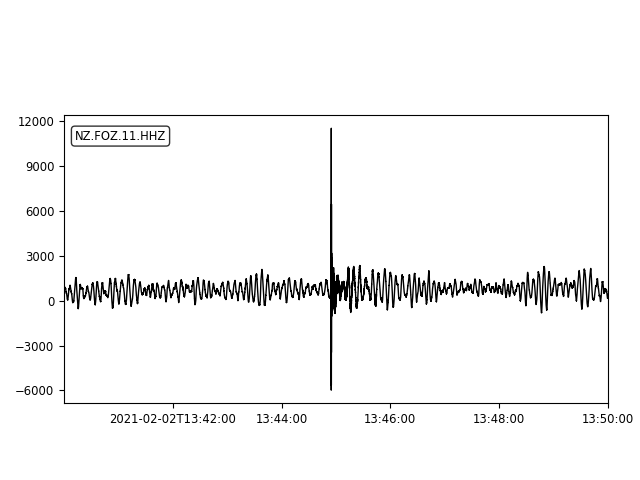

In [31]:
st = client.get_waveforms(
    network="NZ", station="FOZ", location="11", channel="HHZ",  # Location code changed for FOZ.
    starttime=UTCDateTime(2021, 2, 2, 13, 40),
    endtime=UTCDateTime(2021, 2, 2, 13, 50))

# Plot the raw data first
fig = plt.figure()
_ = st.plot(show=False, fig=fig)

plt.show()

Decimation simply removes samples - it runs the real risk of aliasing, so you should filter first.  We won't here, just to see what decimation does.

I will work on a copy of the data to retain the original for later:

1 Trace(s) in Stream:
NZ.FOZ.11.HHZ | 2021-02-02T13:40:00.003133Z - 2021-02-02T13:50:00.003133Z | 20.0 Hz, 12001 samples


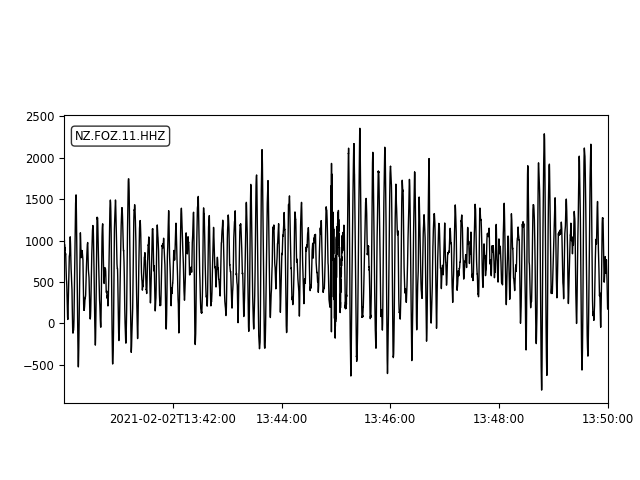

In [32]:
decimated = st.copy()
decimated.decimate(5)
print(decimated)
fig = plt.figure()
_ = decimated.plot(show=False, fig=fig)

plt.show()

That isn't very nice - we lost the high amplitude spike of the earthquake! This decimation only retains every fifth sample, it so happened that the high amplitude sample wasn't one of those retained... Not the best way to reduce sampling rate?

How about resampling in the frequency domain:

1 Trace(s) in Stream:
NZ.FOZ.11.HHZ | 2021-02-02T13:40:00.003133Z - 2021-02-02T13:49:59.953133Z | 20.0 Hz, 12000 samples


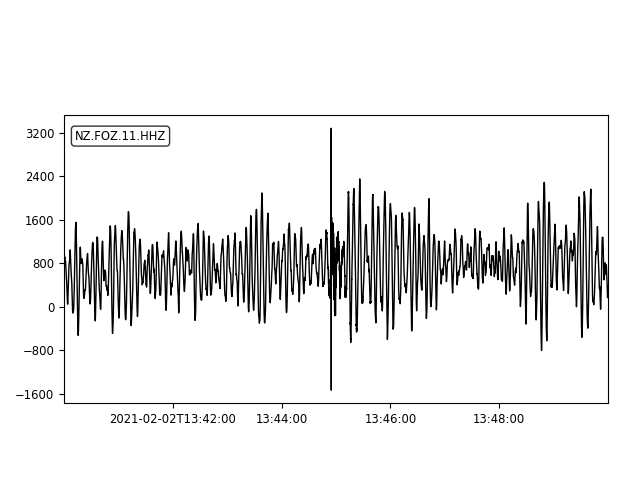

In [33]:
resampled = st.copy()
resampled.resample(20)  # Provide the desired sampling rate
print(resampled)
fig = plt.figure()
_ = resampled.plot(show=False, fig=fig)

plt.show()

That looks much better - there are more issues here that we will talk about next time, and better ways to resample (using the sinc interpolator!).  That is it for now.

Your final exercise is to:
1. Download data for stations within 1 degree of GeoNet event [2023p122368](https://www.geonet.org.nz/earthquake/2023p122368), around the event time (use your function)
2. Filter the data between 1 and 20 Hz
3. Resample the data to a 50 Hz sampling rate
4. Plot the data
5. Plot the spectrogram
6. Compare the frequency content at each station qualitatively.

In [34]:
# Your code here: